<a href="https://www.kaggle.com/code/emanafi/text-to-image-generation-with-birds-using-cgan?scriptVersionId=230384662" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **1. Dataset Setup:**

In [1]:
import os
import pandas as pd

# Define dataset paths
dataset_path = "/kaggle/input/assignment-3-cub200-2011/CUB_200_2011/"
images_folder = os.path.join(dataset_path, "images")
classes_file = os.path.join(dataset_path, "classes.txt")
images_file = os.path.join(dataset_path, "images.txt")
split_file = os.path.join(dataset_path, "train_test_split.txt")

# Load and merge metadata
classes = pd.read_csv(classes_file, sep=" ", header=None, names=["class_id", "class_name"])
images = pd.read_csv(images_file, sep=" ", header=None, names=["image_id", "file_path"])
split = pd.read_csv(split_file, sep=" ", header=None, names=["image_id", "is_train"])

# Merge dataframes
images["class_name"] = images["file_path"].apply(lambda x: x.split("/")[0])
metadata = images.merge(split, on="image_id").merge(classes, on="class_name")
metadata["file_path"] = metadata["file_path"].apply(lambda x: os.path.join(images_folder, x))

# Display sample metadata
print("Sample Metadata:")
print(metadata.head())

Sample Metadata:
   image_id                                          file_path  \
0         1  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
1         2  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
2         3  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
3         4  /kaggle/input/assignment-3-cub200-2011/CUB_200...   
4         5  /kaggle/input/assignment-3-cub200-2011/CUB_200...   

                   class_name  is_train  class_id  
0  001.Black_footed_Albatross         0         1  
1  001.Black_footed_Albatross         1         1  
2  001.Black_footed_Albatross         0         1  
3  001.Black_footed_Albatross         1         1  
4  001.Black_footed_Albatross         1         1  


# **2. Data Preprocessing:**

In [2]:
from transformers import AutoTokenizer
import tensorflow as tf

# Initialize BERT tokenizer with clean_up_tokenization_spaces set to False
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", clean_up_tokenization_spaces=False)

# Tokenize text
def preprocess_text(texts, max_length=128):
    tokens = tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return tokens["input_ids"]

# Preprocess images
def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])  # Ensure images are resized to 64x64
    image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
    return image

# Create dataset pipeline
def create_combined_dataset(metadata):
    file_paths = metadata["file_path"].values
    text_input_ids = preprocess_text(metadata["class_name"])
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, text_input_ids))
    dataset = dataset.map(
        lambda path, text: (preprocess_image(path), text),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(16).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create the dataset
combined_dataset = create_combined_dataset(metadata)

# Display a batch for debugging
for image_batch, text_batch in combined_dataset.take(1):
    print("Image Batch Shape:", image_batch.shape)  # Expected: (16, 64, 64, 3)
    print("Text Batch Shape:", text_batch.shape)    # Expected: (16, 128)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Image Batch Shape: (16, 64, 64, 3)
Text Batch Shape: (16, 128)


# **3. GAN Implementation:**

In [3]:
from tensorflow.keras import layers, Model

# Update the generator to handle the correct text input shape

def build_generator(noise_dim=100, embedding_dim=128):
    noise_input = layers.Input(shape=(noise_dim,))
    text_input = layers.Input(shape=(embedding_dim,))
    combined_input = layers.Concatenate()([noise_input, text_input])

    x = layers.Dense(8 * 8 * 512, use_bias=False)(combined_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((8, 8, 512))(x)

    # Upsample layers with more filters
    x = layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    output = layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', activation='tanh')(x)

    generator = Model([noise_input, text_input], output, name="Generator")
    return generator

# Update the discriminator to handle the correct text input shape

def build_discriminator(image_shape=(64, 64, 3), embedding_dim=128):
    # Image input
    image_input = layers.Input(shape=image_shape)
    
    # Text input: Ensure it has the correct embedding size
    text_input = layers.Input(shape=(embedding_dim,))
    
    # Transform text embedding into something that matches the spatial dimensions
    text_embedding = layers.Dense(units=image_shape[0] * image_shape[1], activation='relu')(text_input)
    
    # Reshape text embedding to match the image spatial layout
    text_embedding = layers.Reshape((image_shape[0], image_shape[1], 1))(text_embedding)

    # Combine image and text embedding
    combined_input = layers.Concatenate()([image_input, text_embedding])
    
    # Apply convolutional layers
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(combined_input)
    x = layers.LeakyReLU()(x)
    # Temporarily remove Dropout layer
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    # x = layers.Dropout(0.3)(x)
    
    # Flatten and output
    x = layers.Flatten()(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Final discriminator model
    discriminator = Model([image_input, text_input], output, name="Discriminator")
    return discriminator

# Define model parameters
noise_dim = 100  # Dimension of random noise vector
embedding_dim = 128  # Dimension of text embeddings

# Build models
generator = build_generator(noise_dim=noise_dim, embedding_dim=embedding_dim)
discriminator = build_discriminator(image_shape=(64, 64, 3), embedding_dim=embedding_dim)

# Print summaries
generator.summary()
discriminator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 228)       │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32768)     │  7,471,104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32768)     │    131,072 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32768)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 8, 8, 512) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  3,276,800 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │    819,200 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │    204,800 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 64, 64, 3) │      4,803 │ leaky_re_lu_3[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 11,909,571 (45.43 MB)

 Trainable params: 11,843,139 (45.18 MB)

 Non-trainable params: 66,432 (259.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4096)      │    528,384 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 64, 1) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64, 4) │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      6,464 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    204,928 │ leaky_re_lu_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │    819,456 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 8, 8, 256) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16384)     │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │     16,385 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,575,617 (6.01 MB)

 Trainable params: 1,575,617 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

# **4. Training the cGAN:**

Epoch 1/1000 | Generator Loss: 5.1673, Discriminator Loss: 11.3623
Epoch 2/1000 | Generator Loss: 1.4311, Discriminator Loss: 2.8478
Epoch 3/1000 | Generator Loss: 0.9390, Discriminator Loss: 1.8807
Epoch 4/1000 | Generator Loss: 0.8172, Discriminator Loss: 1.6504
Epoch 5/1000 | Generator Loss: 0.7735, Discriminator Loss: 1.5493
Epoch 6/1000 | Generator Loss: 0.7522, Discriminator Loss: 1.4993
Epoch 7/1000 | Generator Loss: 0.7329, Discriminator Loss: 1.4665
Epoch 8/1000 | Generator Loss: 0.7141, Discriminator Loss: 1.4335
Epoch 9/1000 | Generator Loss: 0.7618, Discriminator Loss: 1.5966
Epoch 10/1000 | Generator Loss: 0.6951, Discriminator Loss: 1.3920
Epoch 11/1000 | Generator Loss: 0.7643, Discriminator Loss: 1.4302
Epoch 12/1000 | Generator Loss: 1.1084, Discriminator Loss: 1.2237
Epoch 13/1000 | Generator Loss: 1.1819, Discriminator Loss: 1.1032
Epoch 14/1000 | Generator Loss: 2.0628, Discriminator Loss: 0.7993
Epoch 15/1000 | Generator Loss: 2.7597, Discriminator Loss: 0.5780
Epo

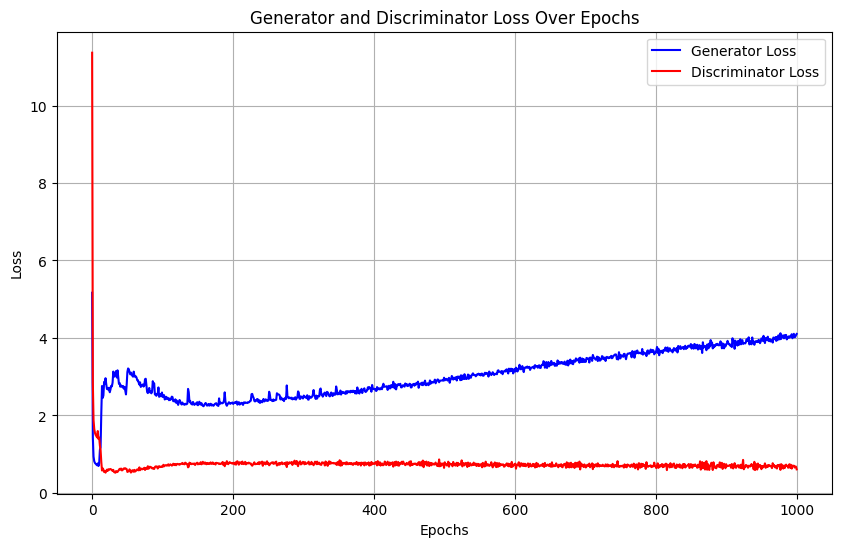

In [4]:
import matplotlib.pyplot as plt

# Loss functions
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss(fake_output):
    return bce_loss(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Optimizers with adjusted learning rates
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Adjusted training loop
@tf.function
def train_step(real_images, text_inputs):
    noise = tf.random.normal([tf.shape(real_images)[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator([noise, text_inputs], training=True)
        real_output = discriminator([real_images, text_inputs], training=True)
        fake_output = discriminator([fake_images, text_inputs], training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Initialize lists to store losses
gen_losses = []
disc_losses = []

# Training loop with logging
num_epochs = 1000  # Reduced for Kaggle
for epoch in range(num_epochs):
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    num_batches = 0

    for image_batch, text_batch in combined_dataset:
        gen_loss, disc_loss = train_step(image_batch, text_batch)

        epoch_gen_loss += gen_loss.numpy()
        epoch_disc_loss += disc_loss.numpy()
        num_batches += 1

    # Compute average loss for the epoch
    avg_gen_loss = epoch_gen_loss / num_batches
    avg_disc_loss = epoch_disc_loss / num_batches

    gen_losses.append(avg_gen_loss)
    disc_losses.append(avg_disc_loss)

    # Print progress
    print(f"Epoch {epoch + 1}/{num_epochs} | Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

# After training, plot the losses
plt.figure(figsize=(10, 6))
plt.plot(gen_losses, label="Generator Loss", color="blue")
plt.plot(disc_losses, label="Discriminator Loss", color="red")
plt.title("Generator and Discriminator Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# **5. Evaluation and Reflection:**

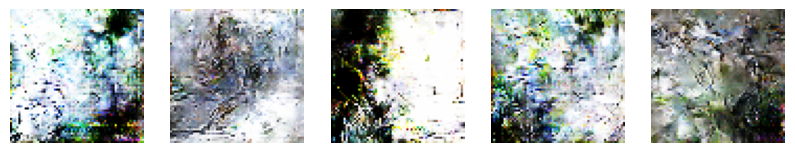

In [5]:
# Generate and visualize synthetic images
def generate_images(generator, metadata, num_images=5):
    noise = tf.random.normal([num_images, 100])
    random_texts = preprocess_text(metadata.sample(num_images)["class_name"])
    generated_images = generator([noise, random_texts], training=False)

    plt.figure(figsize=(10, 5))
    for i, img in enumerate(generated_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((img + 1) / 2)
        plt.axis("off")
    plt.show()

generate_images(generator, metadata)

# **6. Knowledge Questions:**

**1.	GANs often face mode collapse, where the generator produces limited variations of data. What techniques can be introduced to mitigate mode collapse, and how would you evaluate their effectiveness in this assignment’s context?**

_Answer:_

Several strategies can be implemented to address mode collapse in GANs:
1.	Minibatch discrimination: This method enables the discriminator to simultaneously evaluate multiple samples within a batch, helping it identify when the generator creates similar outputs for different inputs.
2.	Feature matching: Rather than solely training the discriminator to differentiate between real and fake data, the generator is also trained to replicate the features of real data as identified by the discriminator.
3.	Unrolled GANs: This approach involves "unrolling" the discriminator's optimization by considering how future updates to the generator might affect its performance. This prevents the discriminator from becoming too dominant too quickly.
4.	Wasserstein GAN (WGAN): WGAN reduces mode collapse by using a loss function that provides smoother gradients, ensuring that the generator avoids getting stuck in a single mode.
In the context of cGANs for text-to-image generation, these methods can be assessed by analyzing the variety in the generated bird images. If the generator produces only a narrow range of bird species or similar images for different textual descriptions, incorporating techniques like minibatch discrimination or feature matching can help foster more diverse outputs.

**2.	Compare and contrast Wasserstein GANs (WGANs) with standard GANs in terms of training stability and convergence. Would WGAN principles be beneficial for the cGAN architecture used here? Why or why not?**

_Answer:_

For training stability and convergence:
- Standard GANs: A common challenge with standard GANs is instability during training. The adversarial loss can cause issues such as vanishing or exploding gradients, particularly when the discriminator becomes too powerful relative to the generator, which can stop the training process.
- WGANs: WGANs tackle these problems by introducing a loss function based on Wasserstein distance (or Earth Mover’s Distance). This results in smoother gradients and more consistent training. Additionally, WGANs replace the sigmoid activation with a linear one in the discriminator, making the loss function less sensitive to variations in the output range.
Regarding the applications of cGANs, incorporating WGAN principles could improve the training stability of the cGAN in this assignment. Since cGANs condition on BERT embeddings, which involve complex, high-dimensional data, the generator may encounter challenges in maintaining stability, especially when generating detailed images like birds. Applying the WGAN techniques could enhance the overall stability during training and reduce the risks of mode collapse or overfitting to specific elements of the textual descriptions.

**3.	How would you assess whether BERT embeddings capture enough semantic information relevant to the bird species in the dataset? Propose a method for evaluating their effectiveness.**

_Answer:_

To determine whether BERT embeddings effectively capture meaningful semantic information about bird species, several evaluation methods can be applied:
- Qualitative: Generate bird images based on textual descriptions and visually compare the results to see if the images accurately represent the described bird species, colors, and specific features such as beak shape or feather texture.
- Quantitative: Employ metrics like cosine similarity or other distance measures to compare the BERT embeddings of the textual descriptions with the features extracted from the generated images. If the feature vectors of the generated images are similar to those of real images, it suggests that the BERT embeddings are capturing the relevant semantic details.
- Doing user studies: Conduct a study where participants are asked to assess how closely the generated images match the textual descriptions. Strong correlations in the ratings would indicate that the BERT embeddings align well with the visual features of the generated images.

**4.	GAN training is inherently unstable due to the adversarial dynamics between the generator and discriminator. Propose a method to detect instability early in the training process and adjust hyperparameters dynamically to stabilize training.**

_Answer:_

The following strategies can be applied to detect instability in GANs early and adjust hyperparameters accordingly:

1.	Monitoring losses: Keeping track of both the generator's and discriminator's losses during training. Significant fluctuations, especially when the discriminator’s loss becomes much smaller than that of the generator, may signal instability.
2.	Gradient clipping: Applying gradient clipping when the magnitude of gradients exceeds a certain threshold, helping to prevent issues like exploding gradients.
3.	Dynamic learning rate adjustment: Using an adaptive learning rate optimizer along with a dynamic learning rate schedule. If instability is observed, lower the learning rate or apply decay to the learning rates of the generator or discriminator to avoid overfitting.
4.	Early stopping: Set up early stopping criteria based on the loss trends or performance on validation data to avoid continuing training when instability is apparent, saving computational resources.

**5.	Discuss the ethical implications of using cGANs in sensitive applications such as healthcare or media generation. What guidelines would you propose for responsible use?**

_Answer:_

The use of cGANs in sensitive fields like healthcare and media generation raises several ethical concerns, such as:
1.	Misinformation and deception: cGANs have the potential to create highly realistic images, which could be used to mislead or deceive people, particularly in media, where deepfakes might be exploited maliciously.
2.	Training data bias: If cGANs are trained on biased or incomplete datasets, they could generate outputs that reinforce these biases, which could be harmful in applications like healthcare, where fairness and representation are crucial.
3.	Privacy issues: In healthcare, GANs could be used to create synthetic medical images, leading to privacy concerns, particularly if such images are used without proper consent.
The guidelines for responsible use that would be proposed are:
- Maintain transparency and accountability regarding the training data and generation processes, especially in sensitive areas.
- Implement ethical guidelines and review systems to ensure fairness, safety, and adherence to legal standards when using GANs.
- Develop methods to detect and prevent harmful or misleading content created by GANs, especially in media and advertising.
- In healthcare, prioritize obtaining patient consent and ensure that synthetic data complies with ethical standards in medical research.

**6.	Text-to-image generation tasks raise concerns about intellectual property rights, especially when trained on publicly available datasets. Analyze how such concerns apply to this assignment and suggest ways to mitigate potential legal risks.**

_Answer:_

Using publicly available datasets for text-to-image generation can raise intellectual property issues in the following situations:
1.	If the generated images closely resemble copyrighted material or if the training data includes copyrighted content.
2.	If the text descriptions include copyrighted elements, such as excerpts from literary works or trademarked content.
Ways to mitigate potential legal risks are:
- Use open datasets: Choose datasets that are explicitly available for commercial and academic purposes, ensuring they come with proper licensing (e.g., CUB-200-2011).
- Data anonymization: Avoid using potentially sensitive or copyrighted text in datasets, ensuring that the textual descriptions do not violate copyright laws.
- Creative commons licensing: Apply the correct Creative Commons or other licenses when using generated images to clarify the usage rights.
- Generate fair use content: Design models to produce content that is original or transformative enough to avoid directly copying copyrighted works.